<a href="https://colab.research.google.com/github/datle2403/datle2403/blob/main/Modeling_Sequential_Data_Using_Recurrent_Neuron_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Representing sequences


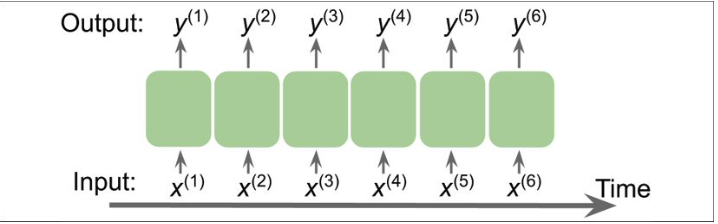

* In DNN or CNN, the model do not have a memory or previously seen training examples

* In contrast, RNN designed for modeling sequences and are camable of remembering past information


common sequence medeling tasks depend on the relationship categories of input and output data:
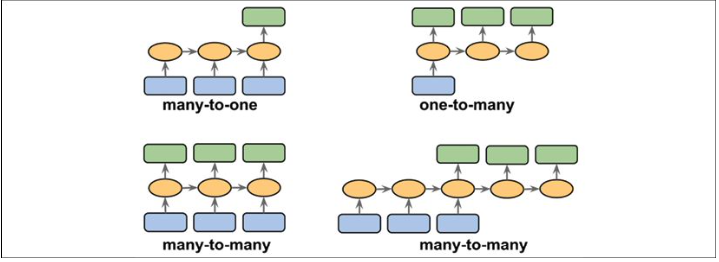

* many-to-one: the input data is a sequence, but the output is scalar or vector
(ex: setiment analysis)

* One to many: the input data is in standard format and not a sequence, but output is a sequence (ex: image captioning: the input is an image and the output is summarizing content of that image)

* Many-to-many: both the input and output are sequences. ex: video classification, where each frame in a video is labeled. This task can be divided into 2 branch, syschronized and delayed (language transformation)


# RNNs for modeling sequences


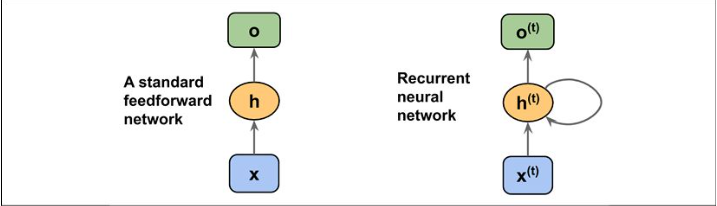

h: is hidden layer

in the right side: o(t) represent sequence as output

* the hidden layer in rnn receives its input from both the input layer of the current time step and hidden layer from the previous time step

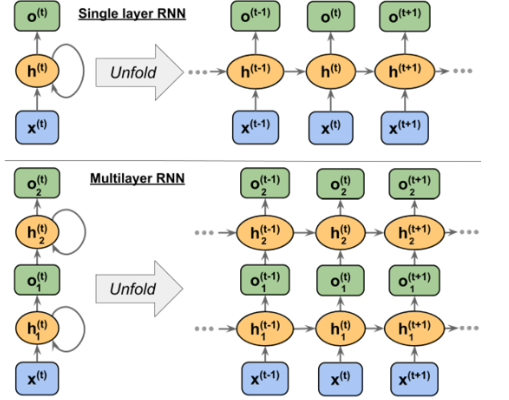

* each hidden unit (h(t-1), h(t),h(t+1)) recieve two distince sets of input- the preactivation from the inputlayer and the activation of previous step

# step

* compute the zh
* compute the h
* compute the o
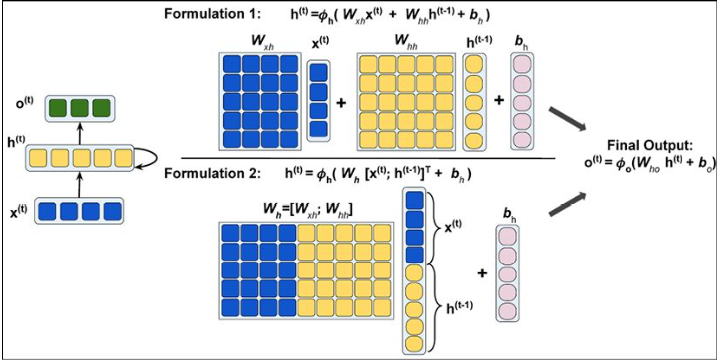

# Compute the activations in an RNN

In [3]:
import tensorflow as tf
tf.random.set_seed(1)
rnn_layer= tf.keras.layers.SimpleRNN(units=2, use_bias= True, return_sequences=True)
rnn_layer.build(input_shape=(None,None,5))

w_xh, w_oo, b_h= rnn_layer.weights
w_xh, w_oo, b_h

(<tf.Variable 'simple_rnn_cell_2/kernel:0' shape=(5, 2) dtype=float32, numpy=
 array([[-0.6200572 ,  0.7433989 ],
        [ 0.242517  , -0.12119704],
        [-0.38525409,  0.2638626 ],
        [ 0.8809836 , -0.12017238],
        [ 0.2964511 ,  0.19422936]], dtype=float32)>,
 <tf.Variable 'simple_rnn_cell_2/recurrent_kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[ 0.98796964,  0.15464693],
        [-0.15464693,  0.9879698 ]], dtype=float32)>,
 <tf.Variable 'simple_rnn_cell_2/bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>)

In [4]:
w_xh.shape, w_oo.shape, b_h.shape

(TensorShape([5, 2]), TensorShape([2, 2]), TensorShape([2]))

In [8]:
x_seq=tf.convert_to_tensor([[1.0]*5, [2.0]*5, [3.0]*5], dtype=tf.float32)
x_input= tf.reshape(x_seq, shape=(1,3,5)) # 1: batch dim, 3: sequence, 5: features
output=rnn_layer(x_input)
output

<tf.Tensor: shape=(1, 3, 2), dtype=float32, numpy=
array([[[0.39240566, 0.74433106],
        [0.80116504, 0.9912947 ],
        [0.95468265, 0.9993069 ]]], dtype=float32)>

In [9]:
out_man=[]
for t in range(len(x_seq)): 
  xt=tf.reshape(x_seq[t],shape=(1,5))
  print(f'Input: {xt.numpy()}')
  ht= tf.matmul(xt,w_xh)+b_h
  if t>0:
    prev_o=out_man[t-1]
  else:
    prev_o=tf.zeros(ht.shape)
  o= ht + tf.matmul(prev_o, w_oo)
  o=tf.math.tanh(o)
  out_man.append(o)

out_man

Input: [[1. 1. 1. 1. 1.]]
Input: [[2. 2. 2. 2. 2.]]
Input: [[3. 3. 3. 3. 3.]]


[<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.39240566, 0.74433106]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.80116504, 0.9912947 ]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.95468265, 0.9993069 ]], dtype=float32)>]

# The challenge of computing long-range interaction

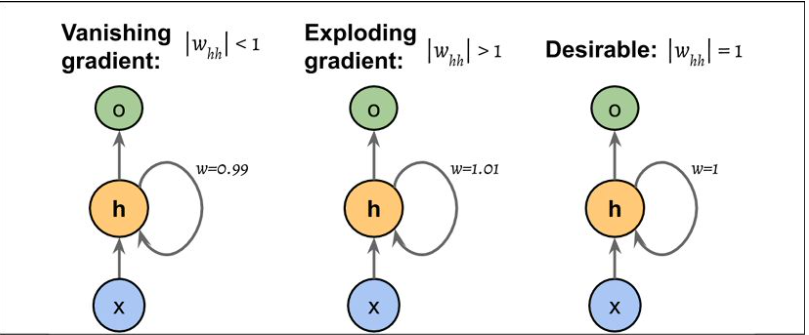

There are ways to solve this problem:
> Gradient clipping: assign thresh hold for gradient

> TBPTT: limit the backpropagation (normal 100 step, limit: recent 20 steps)

> LSTM: long-short term memory

# Long-short term memory

memory cell: replace the standard hidden layers in RNNs

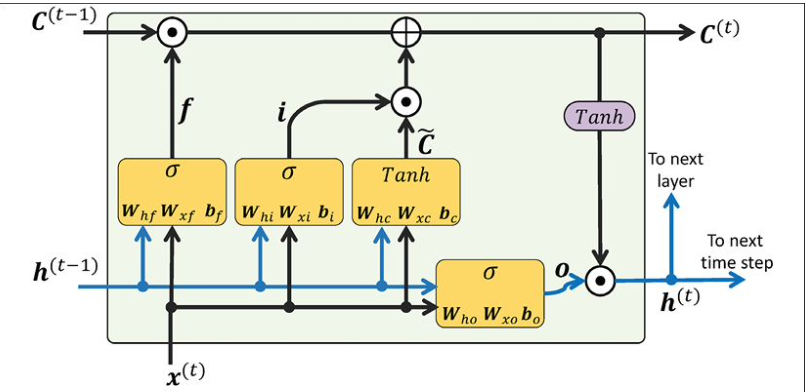

C: is the cell state, h is the hidden layer

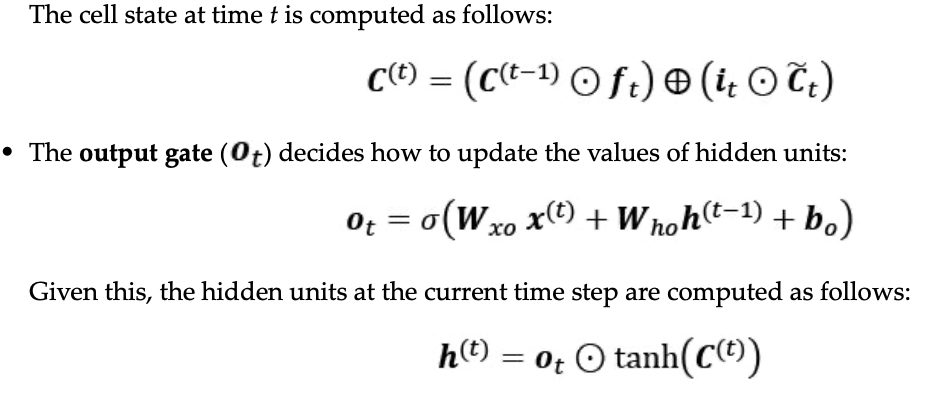

# Project one- predicting the sentiment of IMDb movie review

In [51]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd

df= pd.read_csv('drive/MyDrive/movie_data.csv')
df.head()


,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


In [52]:
target= df.pop('sentiment')

In [53]:
ds_raw= tf.data.Dataset.from_tensor_slices((df.values, target.values))
for ex in ds_raw.take(3):
  print(ex[0].numpy(), ex[1].numpy())

[b'In 1974, the teenager Martha Moxley (Maggie Grace) moves to the high-class area of Belle Haven, Greenwich, Connecticut. On the Mischief Night, eve of Halloween, she was murdered in the backyard of her house and her murder remained unsolved. Twenty-two years later, the writer Mark Fuhrman (Christopher Meloni), who is a former LA detective that has fallen in disgrace for perjury in O.J. Simpson trial and moved to Idaho, decides to investigate the case with his partner Stephen Weeks (Andrew Mitchell) with the purpose of writing a book. The locals squirm and do not welcome them, but with the support of the retired detective Steve Carroll (Robert Forster) that was in charge of the investigation in the 70\'s, they discover the criminal and a net of power and money to cover the murder.<br /><br />"Murder in Greenwich" is a good TV movie, with the true story of a murder of a fifteen years old girl that was committed by a wealthy teenager whose mother was a Kennedy. The powerful and rich fam

In [62]:
tf.random.set_seed(1)
ds_raw= ds_raw.shuffle(buffer_size=50000, reshuffle_each_iteration=False)
ds_raw_test= ds_raw.take(25000)
ds_raw_train_valid= ds_raw.skip(20000)
ds_raw_valid= ds_raw_train_valid.take(20000)
ds_raw_train= ds_raw_train_valid.skip(20000)

In [6]:
## step2: find unique tokens(word)
from collections import Counter
tokenizer= tfds.deprecated.text.Tokenizer()
token_counts= Counter()
for example in ds_raw_train:
  tokens= tokenizer.tokenize(example[0].numpy()[0])
  token_counts.update(tokens)
len(token_counts)

64552

In [8]:
# step3: encoding unique tokens to integer
encoder= tfds.deprecated.text.TokenTextEncoder(token_counts)
exam='this is an example'
encoder.encode(exam)

[11, 3, 199, 1679]

Note that some token in validation or test data are not present in training data, if we have 64552 words seen in training, then new word will be assign to q+1, or it will labled i=unkown word

* we can use map method to transform each example into int vectorize

In [10]:
def encode(text_tensor, label):
  text_numpy= text_tensor.numpy()[0]
  encoded_text= encoder.encode(text_numpy)
  return encoded_text, label
def encode_map_fn(text,label):
  return tf.py_function(encode, inp=(text,label), Tout=(tf.int64, tf.int64))

ds_train= ds_raw_train.map(encode_map_fn)
ds_test= ds_raw_test.map(encode_map_fn)
ds_valid= ds_raw_valid.map(encode_map_fn)

for example in ds_train.shuffle(1000).take(5):
  print(example[0].shape)

(200,)
(105,)
(37,)
(272,)
(135,)


In [11]:
ex= ds_train.take(8)
ds_batch= ex.padded_batch(4, padded_shapes=([-1], []))
for x in ds_batch:
  print(x[0].shape)

(4, 447)
(4, 213)


In [12]:
train_data=ds_train.padded_batch(32, padded_shapes=([-1],[]))
test_data= ds_test.padded_batch(32, padded_shapes=([-1],[]))
valid_data=ds_valid.padded_batch(32, padded_shapes=([-1],[]))

# Embedding layers for sentence encoding


In [17]:
from tensorflow.keras.layers import Embedding
model= tf.keras.Sequential()
model.add(Embedding(input_dim=100, output_dim=6, input_length=20, name='embed-layer'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embed-layer (Embedding)     (None, 20, 6)             600       
                                                                 
Total params: 600
Trainable params: 600
Non-trainable params: 0
_________________________________________________________________


In [19]:
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras import Sequential
model = Sequential()
model.add(Embedding(input_dim=1000, output_dim=32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.add(Dense(1))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          32000     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 36,193
Trainable params: 36,193
Non-trainable params: 0
_________________________________________________________________


In [40]:
embedding_dim=20
vocab_size=len(token_counts)+2
tf.random.set_seed(1)
model= tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        name='embed-layer'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, name='lstm-layer'), name='bidir-lstm'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])
hist=model.fit(train_data, validation_data=valid_data, epochs=10)

print(model.evaluate(test_data))


Epoch 1/10
313/313 [==============================] - 340s 1s/step - loss: 0.6057 - accuracy: 0.6616 - val_loss: 0.4016 - val_accuracy: 0.8287
Epoch 2/10
313/313 [==============================] - 338s 1s/step - loss: 0.2991 - accuracy: 0.8853 - val_loss: 0.4988 - val_accuracy: 0.8185
Epoch 3/10
313/313 [==============================] - 349s 1s/step - loss: 0.1551 - accuracy: 0.9479 - val_loss: 0.5499 - val_accuracy: 0.8304
Epoch 4/10
313/313 [==============================] - 348s 1s/step - loss: 0.0589 - accuracy: 0.9834 - val_loss: 0.6504 - val_accuracy: 0.8231
Epoch 5/10
313/313 [==============================] - 345s 1s/step - loss: 0.0406 - accuracy: 0.9874 - val_loss: 0.8510 - val_accuracy: 0.8030
Epoch 6/10
313/313 [==============================] - 345s 1s/step - loss: 0.0457 - accuracy: 0.9861 - val_loss: 0.9003 - val_accuracy: 0.8177
Epoch 7/10
313/313 [==============================] - 346s 1s/step - loss: 0.0574 - accuracy: 0.9810 - val_loss: 0.7632 - val_accuracy: 0.8040

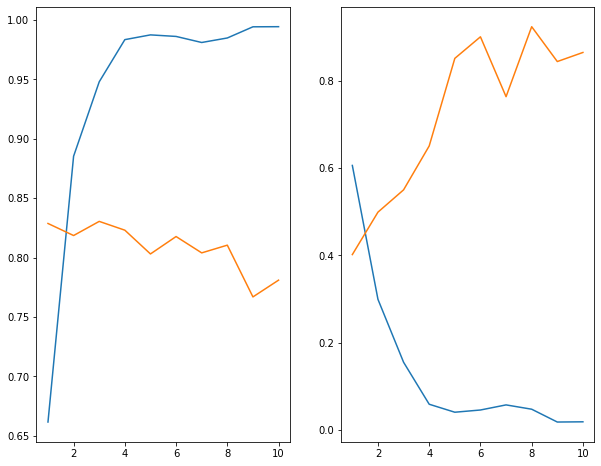

In [41]:
r= range(1,11)
history=hist.history
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(1,2,1)
ax.plot(r, history['accuracy'])
ax.plot(r, history['val_accuracy'])

ax=fig.add_subplot(1,2,2)
ax.plot(r, history['loss'])
ax.plot(r, history['val_loss'])

In [66]:
def preprocess_datasets(
    ds_raw_train, 
    ds_raw_valid, 
    ds_raw_test,
    max_seq_length=None,
    batch_size=32):
    
    ## Step 1: (already done => creating a dataset)
    ## Step 2: find unique tokens
    tokenizer = tfds.deprecated.text.Tokenizer()
    token_counts = Counter()

    for example in ds_raw_train:
        tokens = tokenizer.tokenize(example[0].numpy()[0])
        if max_seq_length is not None:
            tokens = tokens[-max_seq_length:]
        token_counts.update(tokens)

    print('Vocab-size:', len(token_counts))


    ## Step 3: encoding the texts
    encoder = tfds.deprecated.text.TokenTextEncoder(token_counts)
    def encode(text_tensor, label):
        text = text_tensor.numpy()[0]
        encoded_text = encoder.encode(text)
        if max_seq_length is not None:
            encoded_text = encoded_text[-max_seq_length:]
        return encoded_text, label

    def encode_map_fn(text, label):
        return tf.py_function(encode, inp=[text, label], 
                              Tout=(tf.int64, tf.int64))

    ds_train = ds_raw_train.map(encode_map_fn)
    ds_valid = ds_raw_valid.map(encode_map_fn)
    ds_test = ds_raw_test.map(encode_map_fn)

    ## Step 4: batching the datasets
    train_data = ds_train.padded_batch(
        batch_size, padded_shapes=([-1],[]))

    valid_data = ds_valid.padded_batch(
        batch_size, padded_shapes=([-1],[]))

    test_data = ds_test.padded_batch(
        batch_size, padded_shapes=([-1],[]))

    return (train_data, valid_data, 
            test_data, len(token_counts))

In [70]:
def build_rnn_model(embedding_dim, vocab_size,
                    recurrent_type='SimpleRNN',
                    n_recurrent_units=64,
                    n_recurrent_layers=1,
                    bidirectional=True):

    tf.random.set_seed(1)

    # build the model
    model = tf.keras.Sequential()
    
    model.add(
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            name='embed-layer')
    )
    
    for i in range(n_recurrent_layers):
        return_sequences = (i < n_recurrent_layers-1)
            
        if recurrent_type == 'SimpleRNN':
            recurrent_layer = SimpleRNN(
                units=n_recurrent_units, 
                return_sequences=return_sequences,
                name='simprnn-layer-{}'.format(i))
        elif recurrent_type == 'LSTM':
            recurrent_layer = LSTM(
                units=n_recurrent_units, 
                return_sequences=return_sequences,
                name='lstm-layer-{}'.format(i))
        elif recurrent_type == 'GRU':
            recurrent_layer = GRU(
                units=n_recurrent_units, 
                return_sequences=return_sequences,
                name='gru-layer-{}'.format(i))
        
        if bidirectional:
            recurrent_layer = Bidirectional(
                recurrent_layer, name='bidir-'+recurrent_layer.name)
            
        model.add(recurrent_layer)

    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    return model
  

train_data, valid_data, test_data, size= preprocess_datasets(ds_raw_train=ds_raw_train,ds_raw_test=ds_raw_test, ds_raw_valid=ds_raw_valid,batch_size=32, max_seq_length=100)

from tensorflow.keras.layers import Bidirectional
embedding_dim = 20
rnn_model= build_rnn_model(
    embedding_dim, size+2,
    recurrent_type='SimpleRNN', 
    n_recurrent_units=64,
    n_recurrent_layers=1,
    bidirectional=True)
rnn_model.summary()

Vocab-size: 41612
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embed-layer (Embedding)     (None, None, 20)          832280    
                                                                 
 bidir-simprnn-layer-0 (Bidi  (None, 128)              10880     
 rectional)                                                      
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 dense_21 (Dense)            (None, 1)                 65        
                                                                 
Total params: 851,481
Trainable params: 851,481
Non-trainable params: 0
_________________________________________________________________


In [71]:
rnn_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])
history = rnn_model.fit(
    train_data, 
    validation_data=valid_data, 
    epochs=10)

Epoch 1/10
313/313 [==============================] - 42s 128ms/step - loss: 0.6992 - accuracy: 0.4959 - val_loss: 0.6882 - val_accuracy: 0.5479
Epoch 2/10
313/313 [==============================] - 40s 127ms/step - loss: 0.5894 - accuracy: 0.6724 - val_loss: 0.6853 - val_accuracy: 0.6105
Epoch 3/10
313/313 [==============================] - 41s 130ms/step - loss: 0.2597 - accuracy: 0.8867 - val_loss: 0.9296 - val_accuracy: 0.6429
Epoch 4/10
313/313 [==============================] - 40s 126ms/step - loss: 0.0950 - accuracy: 0.9640 - val_loss: 0.8461 - val_accuracy: 0.7123
Epoch 5/10
313/313 [==============================] - 41s 130ms/step - loss: 0.0263 - accuracy: 0.9924 - val_loss: 0.8976 - val_accuracy: 0.7458
Epoch 6/10
313/313 [==============================] - 41s 130ms/step - loss: 0.0132 - accuracy: 0.9965 - val_loss: 1.1306 - val_accuracy: 0.7115
Epoch 7/10
313/313 [==============================] - 41s 130ms/step - loss: 0.0020 - accuracy: 0.9999 - val_loss: 1.1532 - val_ac

# Project 2: character-level language modeling in Tensorflow

In [35]:
import numpy as np

with open('drive/MyDrive/1268-0.txt','r') as fp:
  text=fp.read()

start_index= text.find('THE MYSTERIOUS ISLAND')
end_index=text.find('End of the Project Gutenberg')
text= text[start_index:end_index]
char_set= set(text)
print('unique character: ',len(char_set))
print('lenght text: ', len(text))

unique character:  80
lenght text:  1112350


In [36]:
# Convert text into numeric format
# we will create python dictionary that map each character to an integer
chars_sorted= sorted(char_set)
char2int= {key:value for value,key in enumerate(chars_sorted)}
char_array= np.array(chars_sorted)
text_encoded= np.array([char2int[i] for i in text], dtype=np.int32)


In [37]:
text_encoded[15:21]

array([33, 43, 36, 25, 38, 28], dtype=int32)

In [38]:
char_array[text_encoded[15:21]]

array(['I', 'S', 'L', 'A', 'N', 'D'], dtype='<U1')

In [39]:
# we will use text_encoded to product tensorflow dataset
import tensorflow as tf
ds_text_encoded= tf.data.Dataset.from_tensor_slices(text_encoded)
for x in ds_text_encoded.take(5):
  print(x.numpy(), chars_sorted[x.numpy()])

44 T
32 H
29 E
1  
37 M


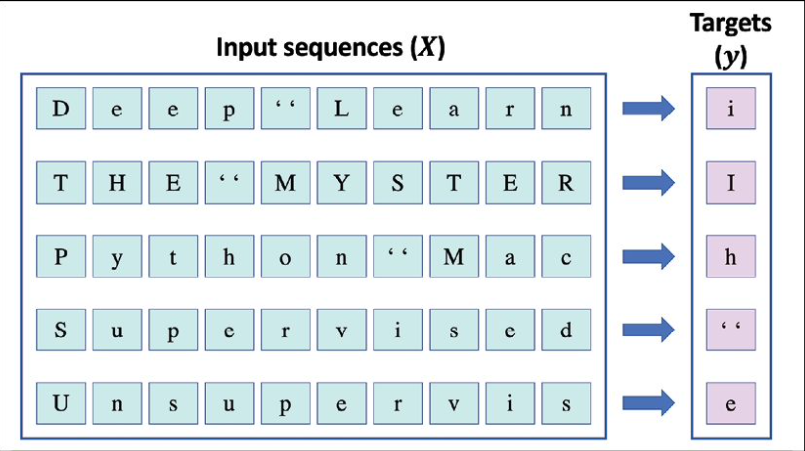

this is classification task

---
let first clip the sequence lenght to 40, this mean that the input tensor x consist of 40 tokens, longer sequences product more meaningful senteces. for shorter sequences, the model might focus on capturing individual words correctly.

the output y is offset by one character. we will split the text into chunks of size41, the last is for y



In [42]:
seq_length=40
chunk_size= seq_length +1
ds_chunks= ds_text_encoded.batch(batch_size= chunk_size, drop_remainder=True)
def split_input_target(chunk):
  lst=chunk
  input= lst[:-1]
  output=lst[1:]
  return input,output
ex= next(iter(ds_chunks.take(1)))
split_input_target(ex)

(<tf.Tensor: shape=(40,), dtype=int32, numpy=
 array([44, 32, 29,  1, 37, 48, 43, 44, 29, 42, 33, 39, 45, 43,  1, 33, 43,
        36, 25, 38, 28,  1,  6,  6,  6,  0,  0,  0,  0,  0, 40, 67, 64, 53,
        70, 52, 54, 53,  1, 51], dtype=int32)>,
 <tf.Tensor: shape=(40,), dtype=int32, numpy=
 array([32, 29,  1, 37, 48, 43, 44, 29, 42, 33, 39, 45, 43,  1, 33, 43, 36,
        25, 38, 28,  1,  6,  6,  6,  0,  0,  0,  0,  0, 40, 67, 64, 53, 70,
        52, 54, 53,  1, 51, 74], dtype=int32)>)

In [43]:
ds_chunks_trans= ds_chunks.map(split_input_target)

In [44]:
for x in ds_chunks_trans.take(2):
  print(repr(''.join(char_array[x[0].numpy()])))
  print(repr(''.join(char_array[x[1].numpy()])))

'THE MYSTERIOUS ISLAND ***\n\n\n\n\nProduced b'
'HE MYSTERIOUS ISLAND ***\n\n\n\n\nProduced by'
' Anthony Matonak, and Trevor Carlson\n\n\n\n'
'Anthony Matonak, and Trevor Carlson\n\n\n\n\n'


In [45]:
from tensorflow.keras import layers
batch_size= 64
buffer_size= 10000
ds= ds_chunks_trans.shuffle(buffer_size).batch(batch_size)
def build_model(vocab_size, embedding_dim, rnn_units):
  model= tf.keras.Sequential()
  model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim))
  model.add(layers.LSTM(rnn_units, return_sequences=True))
  model.add(layers.Dense(units=vocab_size))
  return model
vocab_size= len(char_set)
embedding_dim=256
rnn_units= 512
model= build_model(vocab_size, embedding_dim, rnn_units)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 256)         20480     
                                                                 
 lstm (LSTM)                 (None, None, 512)         1574912   
                                                                 
 dense (Dense)               (None, None, 80)          41040     
                                                                 
Total params: 1,636,432
Trainable params: 1,636,432
Non-trainable params: 0
_________________________________________________________________


as you can see, the lstm has rank 3, the fist dim is number of batch, second for the output sequence length, the last is for number of hidden unit

In [ ]:
model.compile(optimizer= 'adam', loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
model.fit(ds, epochs= 10)

# evaluation phase

Instead of always selecting the character with highest likelihood, we want to sample from the outputs, otherwise the model will always product the same text

Tensorflow has a function called tf.random.categorical(), which we can use to draw random samples from a categorical distribution.

In [47]:
model.save('generating text')

The work_flow: 
> using tf.random.categorical(), we can generate example based on logits computed by our model

> the sample function the recieve short starting string, and generate new string

> then a string of size max_input_length is taken from the end of generated_str and encoded to a sequence of integers, the encoded is pass to rnn_model, since we set return sequence = True, then the out put is vector of 84 elements.

>we use only the last logit to pass to random_categorical to generate new sample. this new sample converted to character and then added to generated string.

> this process is repeated until the lenght of generated string reach to desire value. this is called auto-regression



In [64]:
def sample(model, starting_str, len_generated_tex=100, max_input_length=40, scale_factor=0.1):
  encoded_input= [char2int[i] for i in starting_str]
  encoded_input= tf.reshape(encoded_input,shape=(1,-1)) 
  # (-1,1): take all in 1 dim, then add new axis, (1,-1): add new dim ,then take all 
  generated_str= starting_str
  model.reset_states()
  for i in range(len_generated_tex):
    logits= model(encoded_input)
    logits=tf.squeeze(logits,0)
    #Removes dimensions of size 1 from the shape of a tensor.
    scale_logits= logits * scale_factor
    new_char_indx= tf.random.categorical(scale_logits, num_samples=1)
    new_char_indx= tf.squeeze(new_char_indx)[-1].numpy()
    generated_str+=str(char_array[new_char_indx])
    new_char_indx= tf.expand_dims([new_char_indx],0)
    encoded_input= tf.concat([encoded_input, new_char_indx], axis=1)
    encoded_input= encoded_input[:,-max_input_length:] # take the last max_input_length element
  return generated_str

sample(model, 'boa', scale_factor=0.5)

'boacht. \nNum!,--”\n\n“U\nLNog5”\nIn thisnwest,” obsedver Sackoably\naqudgus.”\n\n“But? Spower,--” shaleveponiz'

the scaling factor can be interpred as the inverse of the temperature in physics. Higher temperature result in more randomness, as scaling factor < 1, the softmax become more uniform

In [2]:
import tensorflow as tf
model= tf.keras.models.load_model('drive/MyDrive/generating text1')

In [14]:
s='hello teacher'
m=[char2int[i] for i in s]
m=tf.reshape(m,shape=(1,-1)) # (5,) ->  shape= 1,5 
logits= model(m)
logits=tf.squeeze(logits,0)
print(logits)

tf.Tensor(
[[  1.3579757    4.631728    -0.35966057 ...  -2.1376953   -9.187352
   -7.869693  ]
 [  4.383248     6.8593035   -1.1905669  ...  -0.16163075 -13.258998
   -3.93194   ]
 [  1.0832744    4.1651       3.1861482  ...  -0.1065863  -10.3558
   -4.8553934 ]
 ...
 [  4.284979     7.08652      2.3215132  ...  -1.2634119  -14.884582
   -4.8126507 ]
 [  0.6132669    3.5699787    1.3834791  ...  -3.029101   -12.218735
   -1.4272946 ]
 [  2.406775     5.2520046    0.7804704  ...  -0.14783126 -11.48793
   -4.457916  ]], shape=(13, 84), dtype=float32)


In [17]:
new_char_indx= tf.random.categorical(logits, num_samples=1) # shape (1,15)
new_char_indx= tf.squeeze(new_char_indx)[-1].numpy()
new_char_indx= tf.expand_dims([new_char_indx],0)# shape= 1,1
print(m) # 1,13 + 1,1 = 1,14
encoded_input= tf.concat([m, new_char_indx], axis=1)
print(encoded_input)
encoded_input= encoded_input[:,-40:]
print(encoded_input)

tf.Tensor([[61 58 65 65 68  1 73 58 54 56 61 58 71]], shape=(1, 13), dtype=int32)
tf.Tensor([[61 58 65 65 68  1 73 58 54 56 61 58 71  1]], shape=(1, 14), dtype=int32)
tf.Tensor([[61 58 65 65 68  1 73 58 54 56 61 58 71  1]], shape=(1, 14), dtype=int32)


In [29]:
j=[i for i in range(50)]
m=tf.constant(j,shape=(1,50))
m[:,-40:]

<tf.Tensor: shape=(1, 40), dtype=int32, numpy=
array([[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
        26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
        42, 43, 44, 45, 46, 47, 48, 49]], dtype=int32)>